In [1]:
import torch
import numpy as np
from influence_utils.parallel import flatten_and_concat

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
import scipy.stats
import matplotlib.pyplot as plt


def get_mean_and_std(v, n, t):
    outputs = torch.load(f"/export/home/Experiments/20200728/{v}-{n}")
    time_1000 = [outputs[f"{v}-{i}-1000"]["time"] / 60 for i in range(t)]
    time_10000 = [outputs[f"{v}-{i}-10000"]["time"] / 60 for i in range(t)]
    print(f"{np.mean(time_1000):.2f} +/- {np.std(time_1000):.2f} {v} K=1000")
    print(f"{np.mean(time_10000):.2f} +/- {np.std(time_10000):.2f} {v} K=10000")
    return outputs


def compute_stest_diff_norm(A, B):
    return (flatten_and_concat(A).cpu() -
            flatten_and_concat(B).cpu()).norm()


def compare_influences(A, B, ax, tolerate=1):
    if set(A.keys()) != set(B.keys()):
        if len(set(A.keys()) - set(B.keys())) > tolerate:
            raise ValueError
        else:
            print(set(A.keys()) - set(B.keys()))
        if len(set(B.keys()) - set(A.keys())) > tolerate:
            raise ValueError
        else:
            print(set(B.keys()) - set(A.keys()))

    influences_A = []
    influences_B = []
    for k in A.keys():
        if k not in B.keys():
            continue
        influences_A.append(A[k])
        influences_B.append(B[k])

    ax.scatter(influences_A, influences_B, alpha=0.25,
                color="salmon", label="Empirical")
    ax.plot(np.linspace(min(influences_A), max(influences_A)),
             np.linspace(min(influences_A), max(influences_A)),
            color="black", label="Perfect")
    ax.legend()
    return (scipy.stats.pearsonr(influences_A, influences_B)[0],
            scipy.stats.spearmanr(influences_A, influences_B)[0])


def compare(As, Bs):
    plt.rcParams["figure.figsize"] = (35, 3)
    fig, axes = plt.subplots(1, 10)
    for i, (A, B) in enumerate(zip(As, Bs)):
        stest_diff = compute_stest_diff_norm(A["s_test"], B["s_test"])
        pr, sr = compare_influences(A["influences"], B["influences"], axes[i])
        axes[i].set_title(f"s_test_diff={stest_diff * 1e5:.2f} 1e-5\npr={pr:.2f} sr={sr:.2f}")

In [3]:
# get_mean_and_std("v3", 50, 50)
# get_mean_and_std("v3-stest", 50, 50)

In [4]:
outputs_v1 = get_mean_and_std("v1", 10, 10)
outputs_v2 = get_mean_and_std("v2", 10, 10)
# outputs_v3 = get_mean_and_std("v3", 50, 10)
outputs_v3 = get_mean_and_std("v3-stest", 50, 10)

10.93 +/- 0.04 v1 K=1000
14.72 +/- 0.21 v1 K=10000
3.13 +/- 0.05 v2 K=1000
6.61 +/- 0.03 v2 K=10000
1.46 +/- 0.07 v3-stest K=1000
2.36 +/- 0.02 v3-stest K=10000


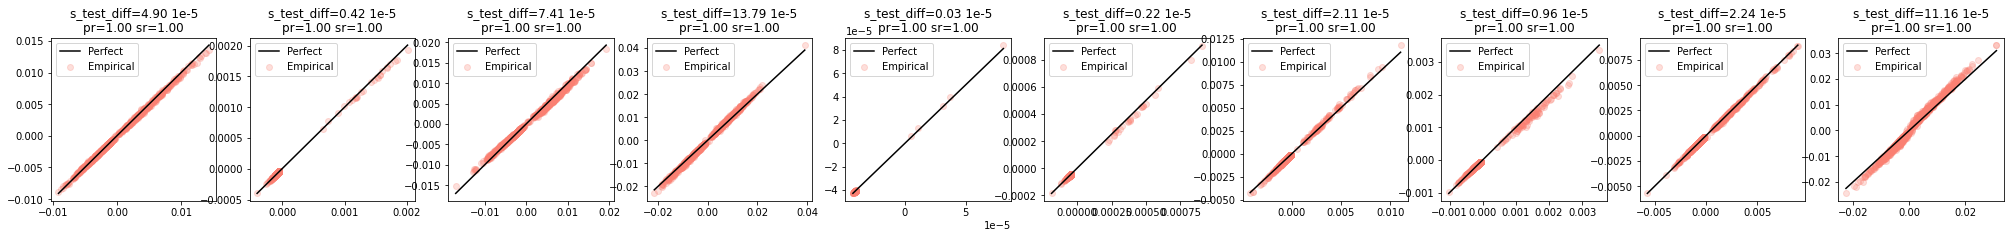

In [5]:
compare(
    [outputs_v2[f"v2-{i}-1000"] for i in range(10)],
    [outputs_v3[f"v3-stest-{i}-1000"] for i in range(10)]
)

{113793}
{334723}


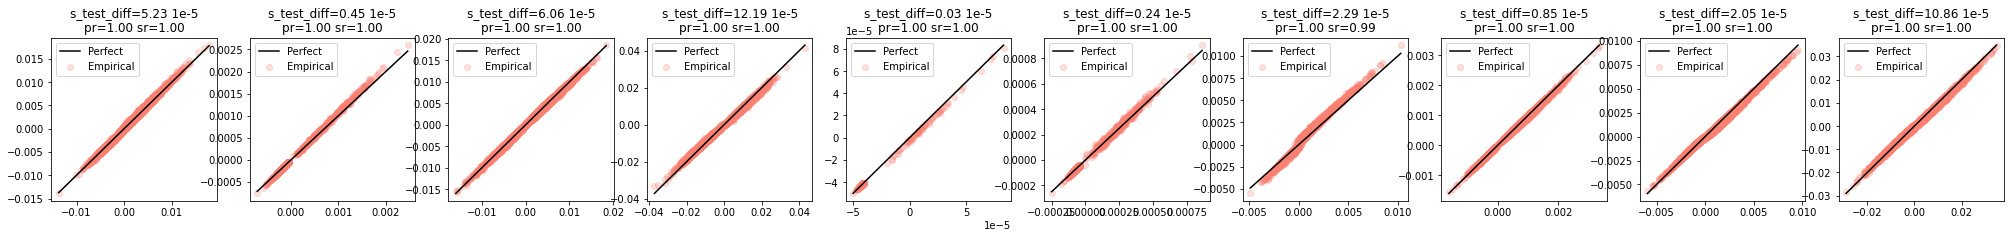

In [6]:
compare(
    [outputs_v2[f"v2-{i}-10000"] for i in range(10)],
    [outputs_v3[f"v3-stest-{i}-10000"] for i in range(10)]
)

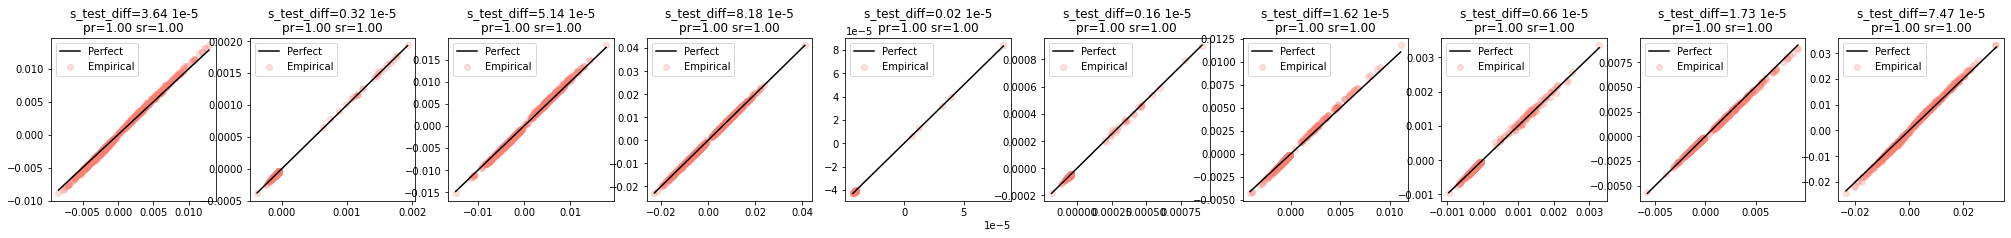

In [7]:
compare(
    [outputs_v1[f"v1-{i}-1000"] for i in range(10)],
    [outputs_v3[f"v3-stest-{i}-1000"] for i in range(10)]
)

{113793}
{334723}


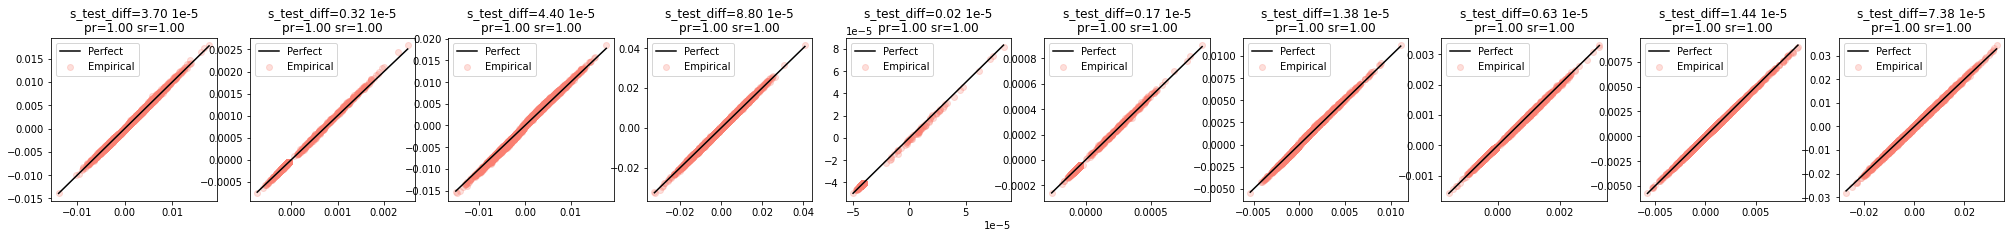

In [8]:
compare(
    [outputs_v1[f"v1-{i}-10000"] for i in range(10)],
    [outputs_v3[f"v3-stest-{i}-10000"] for i in range(10)]
)